In [12]:
"""
Zuerst stellen wir sicher, dass die notwendigen Pakete installiert sind und importieren diese:
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
import copy

from collections import Counter


import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
# Konfiguration für Gerät und Speicherverwaltung
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_memory_flag = torch.cuda.is_available()

# Infoausgabe zur Umgebung
if pin_memory_flag:
    print("✅ CUDA gefunden – pin_memory aktiviert.")
else:
    print("⚠️  Keine GPU gefunden – pin_memory wird ignoriert. Training läuft auf CPU.")


⚠️  Keine GPU gefunden – pin_memory wird ignoriert. Training läuft auf CPU.


In [13]:
"""
Random Seet setzen, damit Ergebnisse reproduzierbar sind
"""

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)

g = torch.Generator()
g.manual_seed(42)


In [14]:
"""
Nun definieren wir Transformatoren für die Daten, laden das Dataset und teilen diese in Trainings- und Validierungsätze auf:
"""
# Definieren Sie Transformationen für das Training und die Validierung
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])
}

# Laden des FGVC-Aircraft-Datensatzes
train_dataset = torchvision.datasets.ImageFolder(root='Data/Train', transform=transform["train"])
test_dataset = torchvision.datasets.ImageFolder(root='Data/Test', transform=transform["test"])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True, generator=g, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True, generator=g, worker_init_fn=seed_worker)

In [15]:
# Normalisierung der Bilder
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


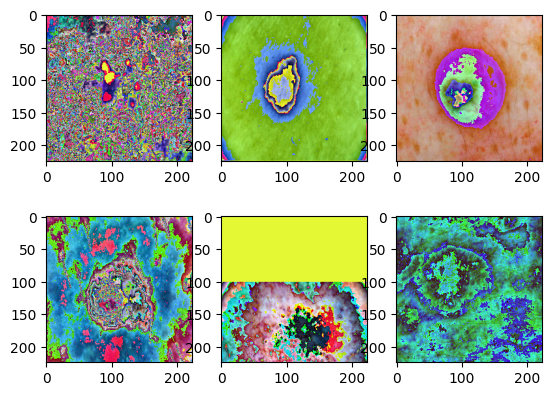

In [16]:
# look at one batch of images
examples = iter(train_loader) # create iterable object
samples, labels = next(examples)  # unpack the batch
# make a plot
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

In [17]:
# Device configuration, Prüfe ob GPU verfügbar ist, falls ja, lasse das Modell auf eie GPU laufen, ansonsten CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Wähle ein Modell aus unter: https://pytorch.org/vision/main/models.html
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# mit diesem Code snippet können wir die Parmeter freeze, sodass diese nicht gelernt werden. Ziel Wir trainieren nur den letzten layer, den wir am Ende hinzufügen.
"""
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False
"""
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [18]:
optimizers_to_test = {
    "SGD_0.01": lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    "SGD_0.001": lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
    "Adam_0.001": lambda params: optim.Adam(params, lr=0.001),
    "Adam_0.0001": lambda params: optim.Adam(params, lr=0.0001),
    "RMSprop_0.001": lambda params: optim.RMSprop(params, lr=0.001),
}


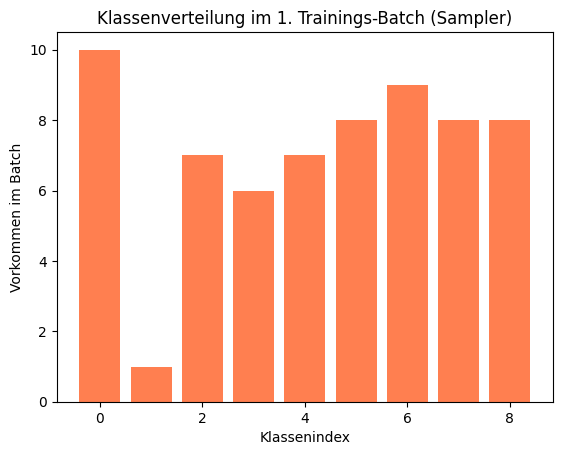

In [19]:
"""
Balanced Sampling mit WeightedRandomSampler für unbalancierte Klassendatensätze.

Dieser Code ersetzt zufälliges Shuffling im DataLoader durch einen gewichteten Sampler,
um Klassenungleichgewichte im Trainingsdatensatz zu kompensieren. Ziel ist es,
jede Klasse proportional gleich häufig im Training zu berücksichtigen.

1. Ziel: Berechne die Sampling-Wahrscheinlichkeit für jedes Bild basierend auf der Seltenheit der Klasse.
2. Ergebnis: Ein ausgewogenes Sampling über alle Klassen im Training, auch bei unbalancierten Daten.

Schritte im Detail:
-------------------
1. targets:
   Extrahiere alle Zielklassen (Labels) aus dem Trainingsdatensatz als Liste.

2. class_counts:
   Zähle, wie oft jede Klasse im Trainingsset vorkommt.

3. class_weights:
   Weise jeder Klasse ein inverses Gewicht zu: je seltener die Klasse, desto höher ihr Gewicht.

4. sample_weights:
   Weise jedem Bild im Trainingsset ein Gewicht basierend auf seiner Klasse zu.
   Diese Liste wird dem Sampler übergeben.

5. sampler:
   Erstelle einen WeightedRandomSampler, der Bilder basierend auf ihren sample_weights zieht.
   → Dadurch erhalten seltene Klassen eine höhere Wahrscheinlichkeit, im Training berücksichtigt zu werden.

6. train_loader:
   Erstelle einen neuen DataLoader, der den Sampler verwendet.
   shuffle=False ist wichtig, da Sampler das Shuffling übernimmt.

7. criterion:
   Verwende einen normalen CrossEntropyLoss, da das Sampling bereits für Ausgleich sorgt.
   (d.h. kein class-weight nötig)

8. Visualisierung (optional):
   Ziehe einen Batch aus dem train_loader und plotte die Klassenverteilung.
   → Zeigt, ob der Sampler tatsächlich für ausgewogene Batches sorgt.
"""
# 1. Zähle Bilder pro Klasse
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)

# 2. Berechne Gewicht pro Sample = 1 / (Anzahl in Klasse)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[t] for t in targets]

# 3. Sampler erzeugen
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 4. Trainingsloader neu definieren mit Sampler (nicht shuffle!)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2, pin_memory=True)

# 5. Loss ohne Gewichtung
criterion = nn.CrossEntropyLoss()

# Optional: Visualisierung der Klassenverteilung im ersten Batch
inputs, labels = next(iter(train_loader))
batch_labels = labels.tolist()

counter = Counter(batch_labels)
plt.bar(counter.keys(), counter.values(), color='coral')
plt.xlabel("Klassenindex")
plt.ylabel("Vorkommen im Batch")
plt.title("Klassenverteilung im 1. Trainings-Batch (Sampler)")
plt.show()



In [20]:
# Zähle alle Labels im Trainingsdatensatz
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
total_samples = sum(class_counts.values())

print("📊 Klassenverteilung im gesamten Trainingsdatensatz (in Prozent):\n")
for cls_idx in sorted(class_counts.keys()):
    count = class_counts[cls_idx]
    percent = (count / total_samples) * 100
    print(f"  Klasse {cls_idx}: {count} Bilder → {percent:.2f}%")

📊 Klassenverteilung im gesamten Trainingsdatensatz (in Prozent):

  Klasse 0: 114 Bilder → 5.09%
  Klasse 1: 376 Bilder → 16.79%
  Klasse 2: 95 Bilder → 4.24%
  Klasse 3: 438 Bilder → 19.56%
  Klasse 4: 357 Bilder → 15.94%
  Klasse 5: 462 Bilder → 20.63%
  Klasse 6: 77 Bilder → 3.44%
  Klasse 7: 181 Bilder → 8.08%
  Klasse 8: 139 Bilder → 6.21%


In [21]:
results = []

for name, opt_func in optimizers_to_test.items():
    print(f"\n🔧 Starte Training mit: {name}")

    # Modell neu initialisieren
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))  # Neue Klassifikation
    model.to(device)

    optimizer = opt_func(model.parameters())

    # Trainingsschleife
    num_epochs = 2
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        pbar = tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}")
        nr_samples = 0
        labels_global = []
        preds_global = []

        for idx, (images, labels) in enumerate(pbar, start=1):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            nr_samples += images.shape[0]
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels)
            labels_global.extend(labels.tolist())
            preds_global.extend(preds.tolist())
            cnt_acc = running_corrects / nr_samples
            cnt_loss = running_loss / nr_samples
            f1 = f1_score(labels_global, preds_global, average='micro')
            pbar.set_description(f'{name} | Loss: {cnt_loss:.3f} | Acc: {cnt_acc:.3f} | F1: {f1:.3f}')

    # Testevaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    results.append((name, acc))
    print(f"✅ {name} → Test Accuracy: {acc:.3%}")



🔧 Starte Training mit: SGD_0.01


SGD_0.01 | Loss: 1.978 | Acc: 0.289 | F1: 0.289: 100%|██████████| 35/35 [03:31<00:00,  6.04s/it]
SGD_0.01 Epoch 2/2:   0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
SGD_0.01 | Loss: 1.439 | Acc: 0.482 | F1: 0.482: 100%|██████████| 35/35 [03:00<00:00,  5.15s/it]
C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ SGD_0.01 → Test Accuracy: 50.000%

🔧 Starte Training mit: SGD_0.001


SGD_0.001 | Loss: 2.199 | Acc: 0.127 | F1: 0.127: 100%|██████████| 35/35 [02:42<00:00,  4.65s/it]
SGD_0.001 Epoch 2/2:   0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
SGD_0.001 | Loss: 2.112 | Acc: 0.230 | F1: 0.230: 100%|██████████| 35/35 [02:47<00:00,  4.79s/it]
C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ SGD_0.001 → Test Accuracy: 34.746%

🔧 Starte Training mit: Adam_0.001


Adam_0.001 | Loss: 1.537 | Acc: 0.444 | F1: 0.444: 100%|██████████| 35/35 [02:48<00:00,  4.81s/it]
Adam_0.001 Epoch 2/2:   0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Adam_0.001 | Loss: 1.115 | Acc: 0.588 | F1: 0.588: 100%|██████████| 35/35 [02:50<00:00,  4.87s/it]
C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Adam_0.001 → Test Accuracy: 52.542%

🔧 Starte Training mit: Adam_0.0001


Adam_0.0001 | Loss: 2.114 | Acc: 0.229 | F1: 0.229: 100%|██████████| 35/35 [02:51<00:00,  4.90s/it]
Adam_0.0001 Epoch 2/2:   0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Adam_0.0001 | Loss: 1.827 | Acc: 0.431 | F1: 0.431: 100%|██████████| 35/35 [02:40<00:00,  4.60s/it]
C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Adam_0.0001 → Test Accuracy: 50.000%

🔧 Starte Training mit: RMSprop_0.001


RMSprop_0.001 | Loss: 1.930 | Acc: 0.295 | F1: 0.295: 100%|██████████| 35/35 [02:40<00:00,  4.59s/it]
RMSprop_0.001 Epoch 2/2:   0%|          | 0/35 [00:00<?, ?it/s]C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
RMSprop_0.001 | Loss: 1.354 | Acc: 0.510 | F1: 0.510: 100%|██████████| 35/35 [02:50<00:00,  4.87s/it]
C:\Users\Ann-Ja\Desktop\Cancer_Data_Collection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ RMSprop_0.001 → Test Accuracy: 51.695%


In [25]:
# Übersicht
results.sort(key=lambda x: x[1], reverse=True)
print("\n📊 Optimizer-Vergleich:")
for name, acc in results:
    print(f"{name:<15} → Accuracy: {acc:.2%}")



📊 Optimizer-Vergleich:
Adam_0.001      → Accuracy: 52.54%
RMSprop_0.001   → Accuracy: 51.69%
SGD_0.01        → Accuracy: 50.00%
Adam_0.0001     → Accuracy: 50.00%
SGD_0.001       → Accuracy: 34.75%


In [23]:
# Trainingsloader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    sampler=sampler,  # falls du einen Sampler benutzt
    num_workers=2,
    pin_memory=pin_memory_flag
)

# Testloader
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=pin_memory_flag
)

errors = []
model.eval()
running_corrects = 0
nr_samples = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels)
    nr_samples += images.shape[0]
    if preds != labels:
      errors.append({"image":images.to("cpu")[0], "y_hat":preds.to("cpu")[0].item(), "label":labels.to("cpu")[0].item()})
print()
print(f"Accuracy on Test dataset: {(running_corrects/nr_samples)*100:.3f} %")



100%|██████████| 118/118 [00:10<00:00, 11.54it/s]


Accuracy on Test dataset: 51.695 %


Label: 0, Prediction: 4


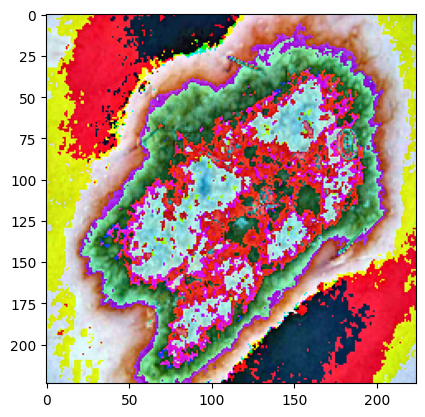

In [24]:
idx = 1
print(f"Label: {errors[idx]['label']}, Prediction: {errors[idx]['y_hat']}")
plt.imshow((errors[idx]['image'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()